In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import logging
import matplotlib.pyplot as plt

tf.get_logger().setLevel(logging.ERROR)

In [3]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [60]:
# Create classes
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [26]:
from tensorflow.keras.utils import to_categorical

X_train = X_train / 255
X_test = X_test / 255

Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

In [27]:
from keras import layers
from keras import models

model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 1024)             

In [30]:
from keras.callbacks import ModelCheckpoint

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"]
)

checkpoint = ModelCheckpoint(
    "../models/newmodel.h5",
    monitor="val_acc",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
)

history = model.fit(
    X_train,
    Y_train,
    batch_size = 64,
    epochs=5,
    validation_split=0.2,
    callbacks=[checkpoint],
)

Epoch 1/5
624/625 [============================>.] - ETA: 0s - loss: 1.7440 - acc: 0.3657
Epoch 1: val_acc improved from -inf to 0.47570, saving model to ../models\newmodel.h5


C:\Users\Lenovo-PC\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 83s 99ms/step - loss: 1.7435 - acc: 0.3659 - val_loss: 1.4745 - val_acc: 0.4757
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 1.3334 - acc: 0.5260
Epoch 2: val_acc improved from 0.47570 to 0.51400, saving model to ../models\newmodel.h5
625/625 [==============================] - 37s 59ms/step - loss: 1.3334 - acc: 0.5260 - val_loss: 1.3486 - val_acc: 0.5140
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 1.1362 - acc: 0.6005
Epoch 3: val_acc improved from 0.51400 to 0.60150, saving model to ../models\newmodel.h5
625/625 [==============================] - 31s 49ms/step - loss: 1.1362 - acc: 0.6005 - val_loss: 1.1561 - val_acc: 0.6015
Epoch 4/5
625/625 [==============================] - ETA: 0s - loss: 1.0120 - acc: 0.6473
Epoch 4: val_acc improved from 0.60150 to 0.64680, saving model to ../models\newmodel.h5
625/625 [==============================] - 32s 52ms/step - loss: 1.0120 - acc: 0.6473 - val_lo

In [8]:
def preprocess_image_input(input_images):
    input_images = input_images.astype("float32")
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims

In [9]:
train_X = preprocess_image_input(X_train)
valid_X = preprocess_image_input(X_test)

In [5]:
def feature_extractor(inputs):

    feature_extractor = tf.keras.applications.resnet.ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )(inputs)
    return feature_extractor

In [6]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [7]:
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [8]:
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(
        optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [9]:
history = model.fit(
    train_X,
    Y_train,
    epochs=3,
    validation_split=0.2,
    batch_size=64,
)

Epoch 1/3
  6/625 [..............................] - ETA: 5:43:33 - loss: 2.3384 - accuracy: 0.1432

: 

In [5]:
model = tf.keras.models.load_model("../models/resnet_best.h5")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [67]:
Y_test_list = Y_test.tolist()

Y_test_named = [[class_names[label[0]]] for label in Y_test_list]

Y_test_named = np.array(Y_test_named)

1/1 [==============================] - 0s 222ms/step
automobile


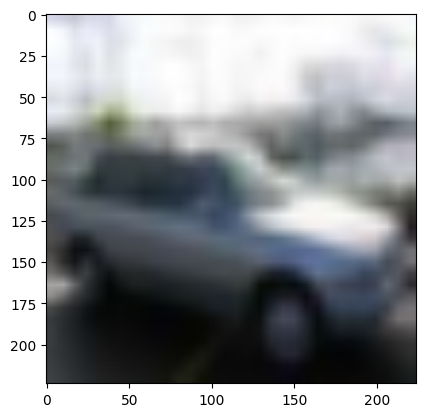

In [81]:
from PIL import Image

example_no = 3857

sample = X_test[example_no].reshape((1, 32, 32, 3))
predict_x = model.predict(sample)

list_x = predict_x.tolist()
sorted_x = sorted(list_x)
pred_num = list_x[0].index(max(list_x[0]))
pred_name = class_names[pred_num]

image = Image.fromarray(X_test[example_no])
img = image.resize((224, 224), Image.BILINEAR)
plt.imshow(img)

print(pred_name)